# Challenge IMA205: Skin Lesion Classification

## Giovanni Benedetti da Rosa

The descriptions provided in the report are organized in two notebooks. In the notebook called "Features-Based.ipynb", there are all the codes related to the features based approach. While in the notebook called "Resnet", there is the training process behind the Resnet, with some analisys of the metadata. 

In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from skimage.io import imread
from skimage.segmentation import chan_vese, watershed
from skimage.draw import ellipse
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.functional import relu


from skimage.color import rgb2lab, lab2rgb
from skimage.segmentation import flood_fill
import skimage.morphology as morpho
from matplotlib import pyplot as plt

from numpy.lib.function_base import median

from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

from skimage.feature import hog, local_binary_pattern
from skimage.feature import local_binary_pattern
from skimage.measure import shannon_entropy, moments_hu
from skimage.exposure import equalize_hist

# Custom transformer class to incorporate ADASYN
from imblearn.over_sampling import ADASYN
from sklearn.base import TransformerMixin, BaseEstimator

from skimage.feature import graycomatrix, graycoprops

from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# Separating the masks from the dataset 

They are going to be used to compare the segmentation method with the ground truth.

The cells below are only separating the dataset.

In [3]:
train_directory = './Train/Train'
test_directory = './Test/Test'

In [ ]:
train_images_filenames = os.listdir(train_directory)
test_images_filenames = os.listdir(test_directory)

train_images_filenames = sorted(train_images_filenames)
test_images_filenames = sorted(test_images_filenames)

train_images = []
train_masks = []
test_images = []
test_masks = []

for image in train_images_filenames:
    if image.endswith('_seg.png'):
        # Save the name without the _seg.png and the image
        name = image[:-8]
        image_name = name + '.jpg'
        mask_image = imread(train_directory + '/' + image)
        image_image = imread(train_directory + '/' + image_name)
        train_masks.append([name, mask_image])
        train_images.append([name, image_image])
   
for image in test_images_filenames:
    if image.endswith('_seg.png'):
        # Save the name without the _seg.png and the image
        name = image[:-8]
        image_name = name + '.jpg'
        mask_image = imread(test_directory + '/' + image)
        image_image = imread(test_directory + '/' + image_name)
        test_masks.append([name, mask_image])
        test_images.append([name, image_image])

In [ ]:
# Create folders to store the exported images
test_export_folder = './Exported_Images/Test'
train_export_folder = './Exported_Images/Train'
os.makedirs(test_export_folder, exist_ok=True)
os.makedirs(train_export_folder, exist_ok=True)

# Export test images
for image in test_images:
    name = image[0]
    image_data = image[1]
    image_path = os.path.join(test_export_folder, f'{name}.jpg')
    cv2.imwrite(image_path, image_data)

# Export train images
for image in train_images:
    name = image[0]
    image_data = image[1]
    image_path = os.path.join(train_export_folder, f'{name}.jpg')
    cv2.imwrite(image_path, image_data)


In [ ]:
# Create folders to store the exported images
test_export_folder = './Exported_Images/Test_Masks'
train_export_folder = './Exported_Images/Train_Masks'
os.makedirs(test_export_folder, exist_ok=True)
os.makedirs(train_export_folder, exist_ok=True)

# Export test images
for image in test_masks:
    name = image[0]
    image_data = image[1]
    image_path = os.path.join(test_export_folder, f'{name}.jpg')
    cv2.imwrite(image_path, image_data)

# Export train images
for image in train_masks:
    name = image[0]
    image_data = image[1]
    image_path = os.path.join(train_export_folder, f'{name}.jpg')
    cv2.imwrite(image_path, image_data)

# First attempt at segmenting images: 
Using the Otsu method with some modifications

In [2]:
def find_good_region(image):
  """Find the region of the image that contains the segmented lesion
     and doesn't contain the black marks. The function returns a binary mask.
  """
  
  _, good_region = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY_INV)
  kernel = morpho.disk(5)

  good_region = cv2.morphologyEx(good_region, cv2.MORPH_OPEN, kernel)
  good_region = cv2.morphologyEx(good_region, cv2.MORPH_CLOSE, kernel)

  flag_painted = 0
  regions = good_region # Initialize regions to avoid errors

  if(good_region[0,0]==255):
    regions = flood_fill(good_region, seed_point=(0,0), new_value=128)
    flag_painted = 1
  if(good_region[image.shape[0]-1,image.shape[1]-1]==255):
    regions = flood_fill(regions, seed_point=(image.shape[0]-1,image.shape[1]-1), new_value=128)
    flag_painted = 1
  if(good_region[0,image.shape[1]-1]==255):
    regions = flood_fill(regions, seed_point=(0,image.shape[1]-1), new_value=128)
    flag_painted = 1
  if(good_region[image.shape[0]-1,0]==255):
    regions = flood_fill(regions, seed_point=(image.shape[0]-1,0), new_value=128)
    flag_painted = 1

  if(flag_painted == 0):
    return np.full_like(image, 255, dtype ='uint8')

  good_region = (255*(regions == 128)).astype('uint8')

  kernel = morpho.disk(30)
  good_region = cv2.morphologyEx(good_region, cv2.MORPH_DILATE, kernel)
  good_region = 255 - good_region
  return good_region

def segmentation(img, good_region, dilate_kernel_size = 16, close_kernel_size = 40, open_kernel_size = 20):
  inner_circle_values = img[(good_region == 255)]

  otsu_threshold, _ = cv2.threshold(inner_circle_values, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  #print("Obtained threshold: ", otsu_threshold)

  segmentation_mask = np.zeros_like(img)
  segmentation_mask = np.where(good_region == 0, 0, segmentation_mask)
  segmentation_mask = np.where((good_region != 0) & (img < otsu_threshold), 255, segmentation_mask)

  #selecting only the region with the biggest area
  open_kernel = morpho.disk(open_kernel_size)
  segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_OPEN, open_kernel)
  dilate_kernel = morpho.disk(dilate_kernel_size)
  segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_DILATE, dilate_kernel)
  close_kernel = morpho.disk(close_kernel_size)
  segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_CLOSE, close_kernel)

  if(np.all(segmentation_mask == 0)): #check if the mask is null everywhere
    return np.full_like(segmentation_mask, 255, dtype ='uint8') # returns the whole image as mask
  
  return segmentation_mask

def DICE_COE(mask_true, mask_prevision):
    #mask_prevision = 255 - mask_prevision #invert the result mask
    intersect = np.sum(mask_true*mask_prevision)
    fsum = np.sum(mask_true>0)
    ssum = np.sum(mask_prevision>0)
    dice = (2 * intersect ) / (fsum + ssum)
    return dice
  
def dice_coefficient(mask1, mask2):
    """
    This function calculates and returns the Dice coefficient of two masks.
    """
    # Flatten the masks
    mask1_flat = mask1.flatten()
    mask2_flat = mask2.flatten()

    # Calculate intersection and union
    intersection = np.sum(mask1_flat * mask2_flat)
    union = np.sum(mask1_flat) + np.sum(mask2_flat)

    # Calculate Dice coefficient
    dice = (2. * intersection) / union

    return dice
  

In [3]:
train_directory = './Exported_Images/Train_Masks'

train_images_filenames = os.listdir(train_directory)

0.9552787682074733


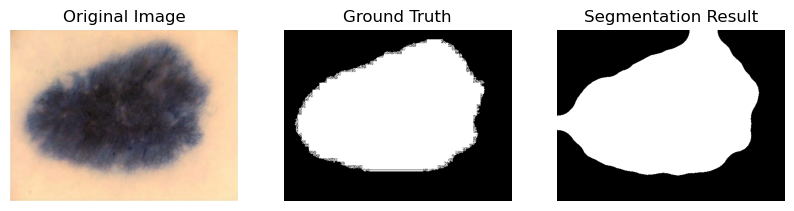

0.7977693344772644


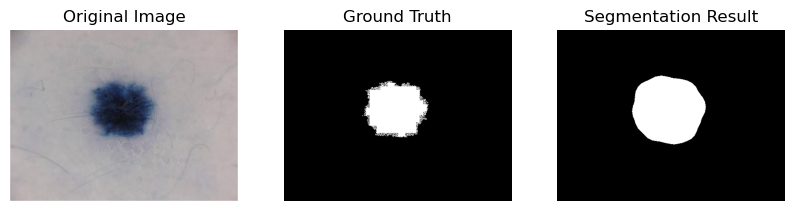

0.9085163667280715


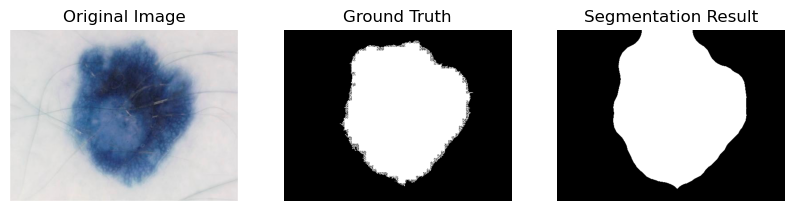

0.807321300397402


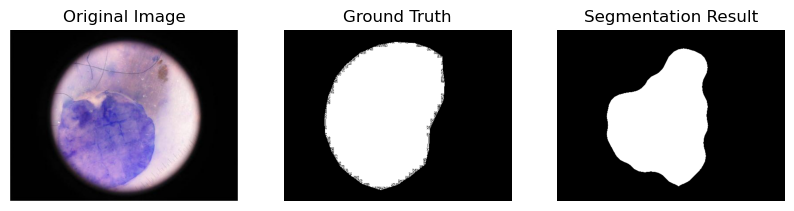

0.8453201465576878


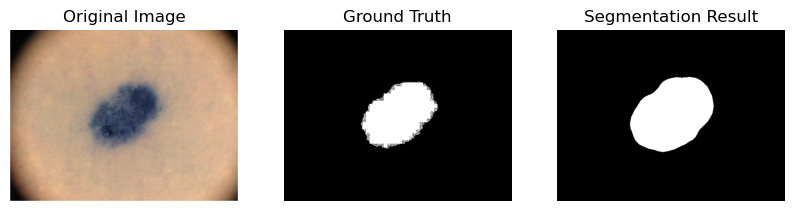

0.9453479548261342


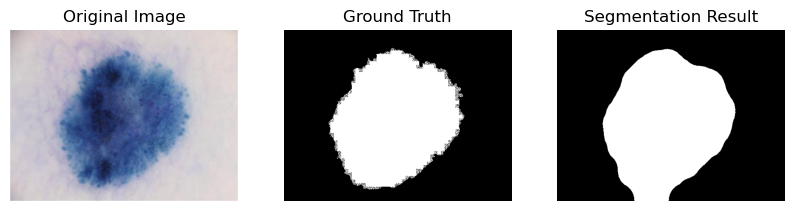

0.9270235647465364


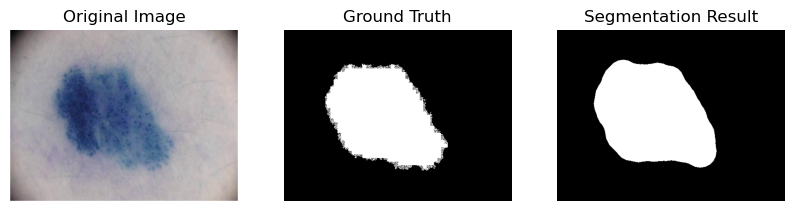

0.7735033771028234


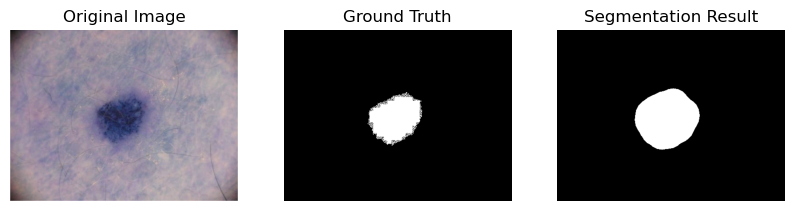

0.9635111749328031


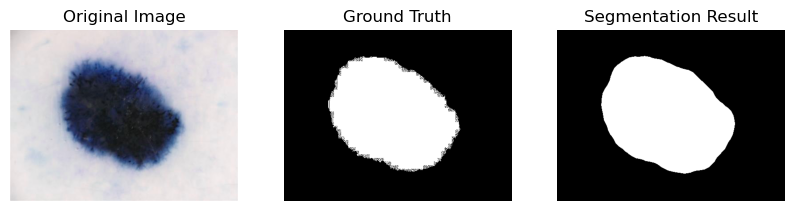

0.9354513423415942


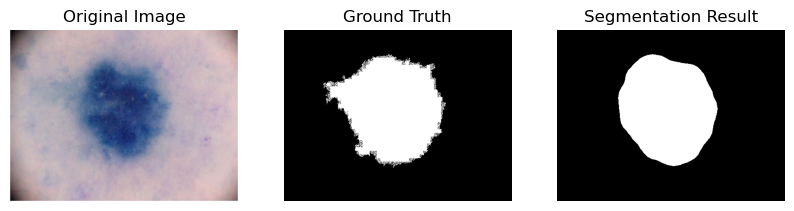

0.8998362072887757


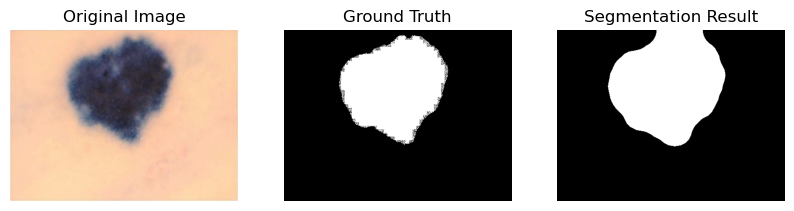

0.9433968611751249


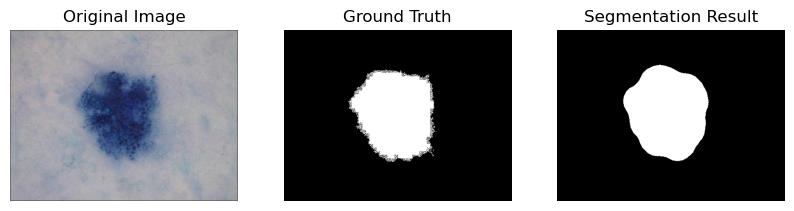

0.950811168098796


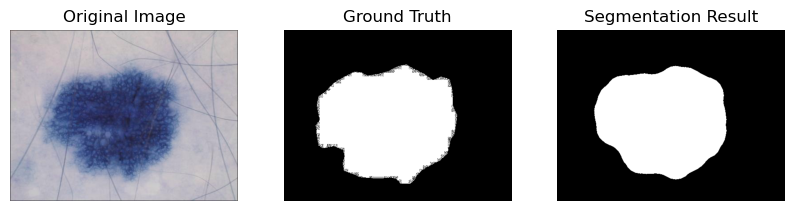

0.8425259401390807


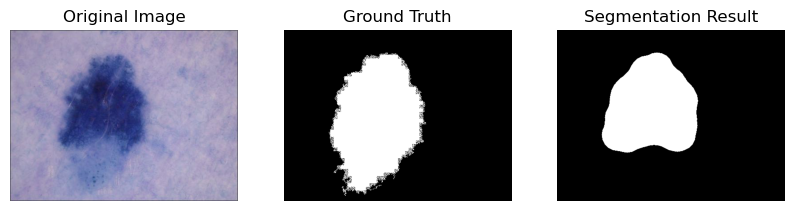

0.8581847482490031


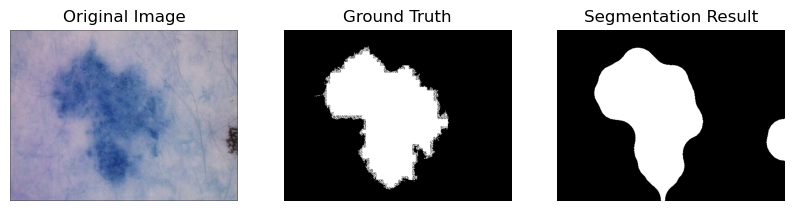

In [4]:
train_directory = './Exported_Images/Train_Masks'
train_images_filenames = os.listdir(train_directory)
#reorder list
train_images_filenames = sorted(train_images_filenames)
dice_scores = []

for i, image in enumerate(train_images_filenames):
    mask_path = f"./Exported_Images/Train_Masks/{image}"
    mask_image = imread(mask_path)
    
    image_path = f"./Exported_Images/Train/{image}"
    image_data = imread(image_path)
    
    
    img_gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)

    good_region = find_good_region(img_gray)

    mask_result = segmentation(img_gray, good_region)
    mask_result = mask_result/255
    mask_result = mask_result.astype('uint8')
    mask_image = mask_image/255
    mask_image = mask_image.astype('uint8')
    
    dice_score = dice_coefficient(mask_image, mask_result)
    dice_scores.append(dice_score)
    
    if i<15:
        print(dice_score)
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(image_data)
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(mask_image, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(mask_result, cmap='gray')
        plt.title('Segmentation Result')
        plt.axis('off')
        plt.show()


In [5]:
np.mean(dice_scores)

0.6154134502875758

# Second approach: 
 
 Segmentating with a U-Net. 

 Checking that the quality of the images have changed when exporting them, we decided now to separate the masks from the original images using their names. In order to run the U-net a data loader from Torch was used.

1. Segmentate the image


In [10]:
class CustomDataset(Dataset):
    def __init__(self, root, file_names, train=False, transform=None):
        self.file_names = file_names
        self.root = root
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        image_filename = self.file_names[index]
        
        if self.train:
            image = Image.open(
                os.path.join(self.root, image_filename + ".jpg")
            ).convert("RGB")
            
            mask = Image.open(
                os.path.join(self.root, image_filename + "_seg.png")
            )

            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
            return image, mask
        else:
            image = Image.open(
                os.path.join(self.root, image_filename + ".jpg")
            ).convert("RGB")

            if self.transform:
                image = self.transform(image)
                
            return image

root_dir = './Train/Train'

directory = './Train/Train'

# List all files in the directory
files = os.listdir(directory)
file_names = []
image_names = []
for file in files:
    if file.endswith('_seg.png'):
        base_name = file.split('_seg')[0]
        file_names.append(base_name)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])#tranfrom the image to tensor

# Define batch size
batch_size = 32

# Instantiate the CustomDataset for training or validation
train_dataset = CustomDataset(root_dir, file_names, train=True, transform=transform)
train_len = int(len(train_dataset) * 0.8)
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

# Create DataLoader for training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create DataLoader for validation dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [6]:
class CustomDataset(Dataset):
    def __init__(self, train_directories, test_directories, train_file_names, test_file_names, transform=None):
        self.train_directories = train_directories
        self.test_directories = test_directories
        self.train_file_names = train_file_names
        self.test_file_names = test_file_names
        self.transform = transform

    def __len__(self):
        return len(self.train_file_names) + len(self.test_file_names)

    def __getitem__(self, index):
        if index < len(self.train_file_names):
            # Load from training directories
            image_filename = self.train_file_names[index]
            directories = self.train_directories
            train = True
        else:
            # Load from test directories
            image_filename = self.test_file_names[index - len(self.train_file_names)]
            directories = self.test_directories
            train = False

        images = []
        masks = []

        for directory in directories:
            if train:
                image_path = os.path.join(directory, image_filename + ".jpg")
                mask_path = os.path.join(directory, image_filename + "_seg.png")

                image = Image.open(image_path).convert("RGB")
                mask = Image.open(mask_path)

                if self.transform:
                    image = self.transform(image)
                    mask = self.transform(mask)

                images.append(image)
                masks.append(mask)
            else:
                image_path = os.path.join(directory, image_filename + ".jpg")
                image = Image.open(image_path).convert("RGB")

                if self.transform:
                    image = self.transform(image)

                images.append(image)

        if train:
            return images, masks
        else:
            return images


train_directories = './Train/Train'
test_directories = './Test/Test'


# List all files in the training directory
train_files = os.listdir(train_directories)
train_file_names = []
for file in train_files:
    if file.endswith('_seg.png'):
        base_name = file.split('_seg')[0]
        train_file_names.append(base_name)

# List all files in the testing directory
test_files = os.listdir(test_directories )
test_file_names = []
for file in test_files:
    if file.endswith('_seg.png'):
        base_name = file.split('_seg')[0]
        test_file_names.append(base_name)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Define batch size
batch_size = 32
        

# Use the DataLoader as before
train_len = int(len(train_dataset) * 0.8)
val_len = len(train_dataset) - train_len

train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

# Create DataLoader for training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create DataLoader for validation dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out
    
num_classes = 1
learning_rate = 0.001    


In [12]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(1))

cuda:2
Tesla V100S-PCIE-32GB


In [ ]:
num_classes = 1
learning_rate = 0.0001    

# Instantiate your UNet model
model = UNet(n_class=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Wrap the train_loader with tqdm for progress bar
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Move data to the same device as the model
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
            
            # Update tqdm progress bar description
            pbar.set_description(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}')
            pbar.update(1)  # Update tqdm progress bar
        
        # Step the scheduler based on validation loss
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)
        
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)
    
    # Compute training loss
    train_loss = running_loss / len(train_loader.dataset)
    
    # Compute validation loss
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'unet_model_test.pth')


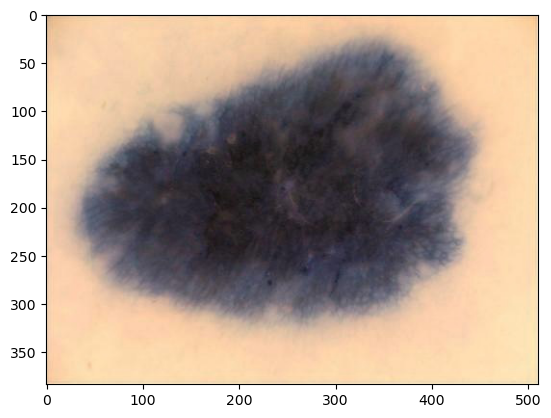

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])
(224, 224)


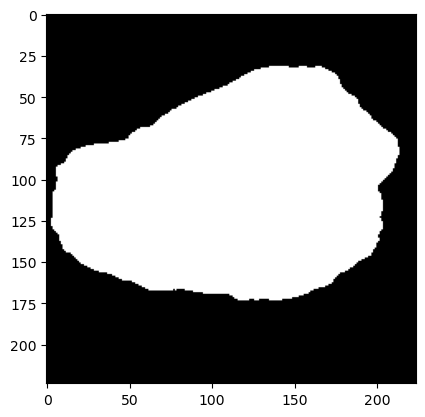

In [15]:
# Load the model
model = UNet(1)
model.load_state_dict(torch.load('unet_model2.pth'))
model.eval()

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

path = './Exported_Images/Train/ISIC_0000000.jpg'

# Load and preprocess input image(s)
input_image = Image.open(path)
input_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension
plt.imshow(input_image, cmap='gray')
plt.show()

print(input_tensor.shape)
# Forward pass
with torch.no_grad():
    output = model(input_tensor)

print(output.shape)
output_image = output.squeeze().cpu().numpy() 
print(output_image.shape)# Assuming output is a single-channel segmentation mask
output_image = (output_image > 0.5).astype('uint8') * 255  # Thresholding
output_image = Image.fromarray(output_image)
plt.imshow(output_image, cmap='gray')

## Outputs and average Dice_score

Average Dice Score: 0.8309681735799284


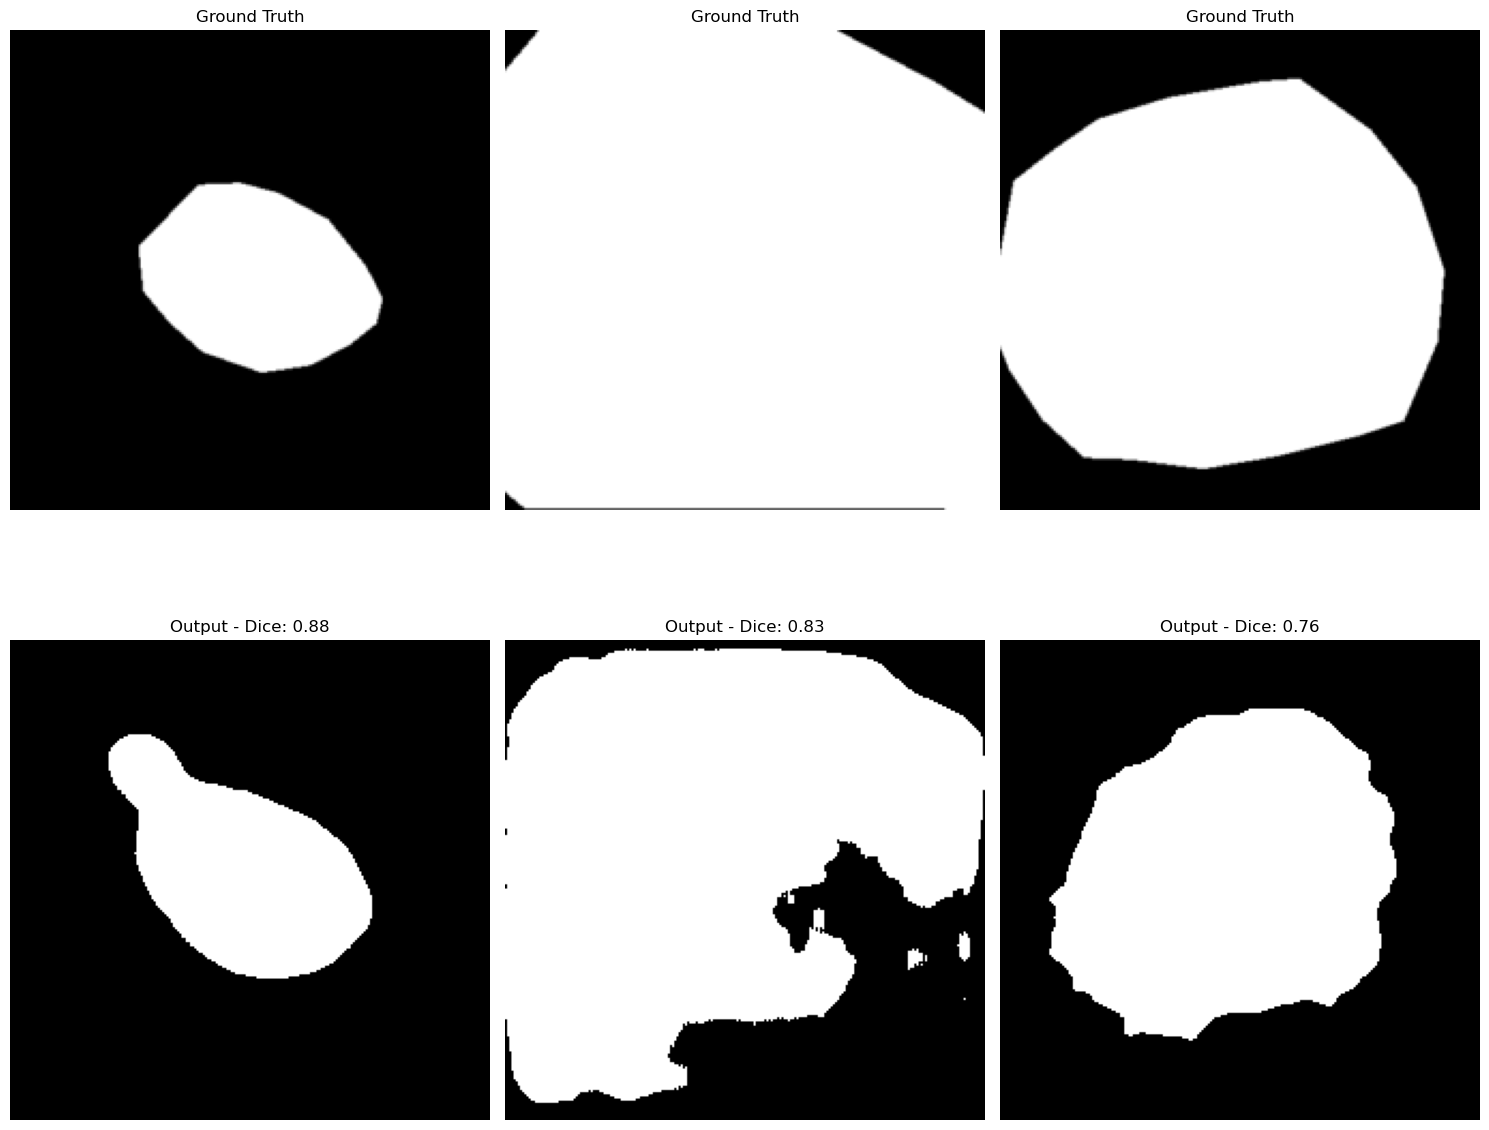

In [16]:
model = UNet(1)
model.load_state_dict(torch.load('unet_model2.pth'))
model = model.to(device)  # Move model to the desired device
model.eval()

def dice_score(pred, target, smooth=1):
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

dice_scores = []

# Create a figure
fig, axs = plt.subplots(2, 3, figsize=(15, 15))

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)  # Move input data to the desired device
        masks = masks.to(device)
        
        outputs = model(images)
        
        output_image = outputs.squeeze(1).cpu().numpy() 
        output_image = (output_image > 0.5).astype('uint8')  # Thresholding

        # Convert masks to numpy arrays
        masks_np = masks.squeeze().cpu().numpy()

        # Calculate Dice score for each sample in the batch
        for i in range(len(output_image)):
            dice = dice_score(masks_np[i],output_image[i])
            dice_scores.append(dice)

            # Plot the masks and their corresponding outputs from index 3 to 5
            if 3 <= i < 6:
                axs[0, i-3].imshow(masks_np[i], cmap='gray')
                axs[0, i-3].axis('off')
                axs[0, i-3].set_title('Ground Truth')   

                axs[1, i-3].imshow(output_image[i], cmap='gray')
                axs[1, i-3].axis('off')
                axs[1, i-3].set_title(f'Output - Dice: {dice:.2f}')

average_dice_score = np.mean(dice_scores)

print("Average Dice Score:", average_dice_score)
plt.subplots_adjust(hspace=0.005, wspace=0.5)

plt.tight_layout()
plt.show()

# Exporting the generated Masks

In [ ]:
model = UNet(1)
model.load_state_dict(torch.load('unet_model2.pth'))
model = model.to(device) 
model.eval()



transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
input_folder = "./Train/Train"

output_folder = "./segmentationTrain"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

dice_scores = []

# Iterate through all image files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):  # Assuming all images end with .jpg
        image_path = os.path.join(input_folder, filename)
    
        image = Image.open(image_path).convert("RGB")
        
        image =  transform(image)
        image_tensor = image.unsqueeze(0).to(device)
        # Convert image to tensor and move to device

        #pass trough the model
        with torch.no_grad():
            output = model(image_tensor)        

        output_image = output.squeeze(0).squeeze(0).cpu().numpy()  # Convert output to numpy array

        # Thresholding if needed
        output_image = (output_image > 0.5).astype('uint8')

        # Save segmented output
        output_filename = os.path.splitext(filename)[0] + "_segmented.jpg"
        output_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_path, output_image * 255)  # Save as uint8 (0-255)


        # Print progress
        print(f"Segmentation saved for {filename}")


In [ ]:

model = UNet(1)
model.load_state_dict(torch.load('unet_model2.pth'))
model = model.to(device) 
model.eval()



transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

input_folder = "./Test/Test"

output_folder = "segmentationTest"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

dice_scores = []

# Iterate through all image files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):  # Assuming all images end with .jpg
        image_path = os.path.join(input_folder, filename)
    
        image = Image.open(image_path).convert("RGB")
        
        image =  transform(image)
        image_tensor = image.unsqueeze(0).to(device)
        # Convert image to tensor and move to device

        # Perform inference
        with torch.no_grad():
            output = model(image_tensor)        

        output_image = output.squeeze(0).squeeze(0).cpu().numpy()  # Convert output to numpy array

        # Thresholding if needed
        output_image = (output_image > 0.5).astype('uint8')

        # Save segmented output
        output_filename = os.path.splitext(filename)[0] + "_segmented.jpg"
        output_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_path, output_image * 255)  # Save as uint8 (0-255)

# Computing Features



In [20]:
def compute_geometric_features(mask):
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize feature values
    area = perimeter = circularity = bulkiness = solidity = eccentricity = np.nan

    # If contours are found
    if contours:
        # Compute area and perimeter
        area = cv2.contourArea(contours[0])
        perimeter = cv2.arcLength(contours[0], True)

        # Compute circularity
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0

        # Compute convex hull and hull area
        hull = cv2.convexHull(contours[0])
        hull_area = cv2.contourArea(hull)

        # Compute solidity
        if hull_area != 0:
            solidity = float(area) / hull_area

        # Compute eccentricity
        if len(contours[0]) >= 5:
            _, (major_axis, minor_axis), _ = cv2.fitEllipse(contours[0])
            if major_axis != 0:
                eccentricity = np.sqrt(1 - (minor_axis ** 2) / (major_axis ** 2))

    return area, perimeter, circularity, bulkiness, solidity, eccentricity


def compute_border_gradient(masked_image):
    # Split the masked image into its color channels
    b, g, r = cv2.split(masked_image)

    # Initialize lists to store mean and standard deviation for each channel
    mean_gradients = []
    std_gradients = []

    # Compute gradients for each color channel
    for channel in (b, g, r):
        # Compute gradients along the border using Sobel operator
        sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=3)

        # Compute gradient magnitude
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

        # Compute mean and standard deviation of gradient magnitudes
        mean_gradient = np.mean(gradient_magnitude)
        std_gradient = np.std(gradient_magnitude)

        # Append mean and standard deviation to respective lists
        mean_gradients.append(mean_gradient)
        std_gradients.append(std_gradient)

    return tuple(mean_gradients), tuple(std_gradients)

def compute_lbp_histogram(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Define LBP operator parameters
    radius = 2
    num_points = 8
    
    # Compute LBP patterns
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')
    
    # Calculate occurrence histogram of unique uniform rotation invariant binary patterns
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    
    return hist.astype(np.float32)

def compute_texture_features(masked_image):
    # Convert the masked image to grayscale
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    
    # Compute GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, distances=distances, angles=angles, symmetric=True, normed=True)
    
    # Compute GLCM properties
    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    
    return contrast, correlation, energy, homogeneity


def compute_channel_stats(masked_image):
    # Split the masked image into its RGB channels
    b, g, r = cv2.split(masked_image)
    
    # Compute mean and standard deviation for each channel
    b_mean = np.mean(b)
    g_mean = np.mean(g)
    r_mean = np.mean(r)
    
    b_std = np.std(b)
    g_std = np.std(g)
    r_std = np.std(r)
    
    return (b_mean, g_mean, r_mean), (b_std, g_std, r_std)


def compute_hu_moments(mask):
    # Compute Hu moments
    moments = cv2.moments(mask)
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments

def compute_hog_features(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute HOG features
    features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys')

    return features




In [ ]:


# Function to compute ORB keypoints and descriptors
def compute_orb_features(image):
    orb = cv2.ORB_create(nfeatures=100)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

# Define the folders containing the images and masks
images_folder = "./Train/Train"
masks_folder = "./segmentationTrain"

# Initialize an empty list to store the data
data = []

# Iterate through all images in the images folder
for image_file in os.listdir(images_folder):
    if image_file.endswith(".jpg"):
        image_path = os.path.join(images_folder, image_file)
        image = cv2.imread(image_path)

        # Load the corresponding mask
        mask_file = os.path.splitext(image_file)[0] + "_segmented.jpg"
        mask_path = os.path.join(masks_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.convertScaleAbs(mask)
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        if np.count_nonzero(mask) == 0:
            # Mask is full of zeros, return the original image
            masked_image = image
        else:
            # Apply the mask to the image
            masked_image = cv2.bitwise_and(image, image, mask=mask)

        # Compute features
        area, perimeter, circularity, bulkiness, solidity, eccentricity = compute_geometric_features(mask)
        mean_border, std_border = compute_border_gradient(masked_image)
        channel_means, channel_stds = compute_channel_stats(masked_image)
        contrast, correlation, energy, homogeneity = compute_texture_features(masked_image)
        lbp_histogram = compute_lbp_histogram(masked_image)
        fractal_dimension = shannon_entropy(mask)
        hu_moments = compute_hu_moments(mask)

        # Detect ORB keypoints and descriptors
        keypoints, descriptors = compute_orb_features(masked_image)

        # Initialize features dictionary for the current image
        image_data = {
            "Image": image_file,
            "Area": area,
            "Perimeter": perimeter,
            "Circularity": circularity,
            "Bulkiness": bulkiness,
            "Solidity": solidity,
            "Eccentricity": eccentricity,
            "Red_Border_Gradient_Mean": mean_border[0],
            "Red_Border_Gradient_Std": std_border[0],
            "Green_Border_Gradient_Mean": mean_border[1],
            "Green_Border_Gradient_Std": std_border[1],
            "Blue_Border_Gradient_Mean": mean_border[2],
            "Blue_Border_Gradient_Std": std_border[2],
            "Red_Mean": channel_means[0],
            "Red_Std": channel_stds[0],
            "Green_Mean": channel_means[1],
            "Green_Std": channel_stds[1],
            "Blue_Mean": channel_means[2],
            "Blue_Std": channel_stds[2],
            "Contrast": contrast,
            "Correlation": correlation,
            "Energy": energy,
            "Homogeneity": homogeneity,
            "Fractal_Dimension": fractal_dimension
        }

        # Append LBP histogram bins as separate features
        for i, bin_value in enumerate(lbp_histogram):
            image_data[f"LBP_Bin_{i}"] = bin_value

        # Append Hu Moments as separate features
        for i, moment_value in enumerate(hu_moments):
            image_data[f"Hu_Moment_{i}"] = moment_value

        # Append ORB descriptors' mean, std, and keypoint response as separate features
        if keypoints is not None and descriptors is not None:
            for kp_idx, (kp, descriptor) in enumerate(zip(keypoints[:32], descriptors[:32])):
                # Compute mean and std of the descriptor vector
                descriptor_mean = np.mean(descriptor) if descriptor is not None else 0
                descriptor_std = np.std(descriptor) if descriptor is not None else 0

                # Append mean and std to the features dictionary
                image_data[f"ORB_Descriptor_Mean_{kp_idx}"] = descriptor_mean
                image_data[f"ORB_Descriptor_Std_{kp_idx}"] = descriptor_std

                # Append the response of the keypoint
                image_data[f"ORB_KeyPoint_Response_{kp_idx}"] = kp.response

            # Fill in missing ORB descriptors with zeros
            if len(keypoints) < 32:
                for kp_idx in range(len(keypoints), 32):
                    image_data[f"ORB_Descriptor_Mean_{kp_idx}"] = 0
                    image_data[f"ORB_Descriptor_Std_{kp_idx}"] = 0
                    image_data[f"ORB_KeyPoint_Response_{kp_idx}"] = 0

        # Append the features of the current image to the data list
        data.append(image_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.measure import shannon_entropy, moments_hu
from skimage.exposure import equalize_hist

# Function to compute ORB keypoints and descriptors
def compute_orb_features(image):
    orb = cv2.ORB_create(nfeatures=100)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

# Define the folders containing the images and masks
images_folder = "./Test/Test"
masks_folder = "./segmentationTest"

# Initialize an empty list to store the data
data = []

# Iterate through all images in the images folder
for image_file in os.listdir(images_folder):
    if image_file.endswith(".jpg"):
        image_path = os.path.join(images_folder, image_file)
        image = cv2.imread(image_path)

        # Load the corresponding mask
        mask_file = os.path.splitext(image_file)[0] + "_segmented.jpg"
        mask_path = os.path.join(masks_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.convertScaleAbs(mask)
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        if np.count_nonzero(mask) == 0:
            # Mask is full of zeros, return the original image
            masked_image = image
        else:
            # Apply the mask to the image
            masked_image = cv2.bitwise_and(image, image, mask=mask)

        # Compute features
        area, perimeter, circularity, bulkiness, solidity, eccentricity = compute_geometric_features(mask)
        mean_border, std_border = compute_border_gradient(masked_image)
        channel_means, channel_stds = compute_channel_stats(masked_image)
        contrast, correlation, energy, homogeneity = compute_texture_features(masked_image)
        lbp_histogram = compute_lbp_histogram(masked_image)
        fractal_dimension = shannon_entropy(mask)
        hu_moments = compute_hu_moments(mask)

        # Detect ORB keypoints and descriptors
        keypoints, descriptors = compute_orb_features(masked_image)

        # Initialize features dictionary for the current image
        image_data = {
            "Image": image_file,
            "Area": area,
            "Perimeter": perimeter,
            "Circularity": circularity,
            "Bulkiness": bulkiness,
            "Solidity": solidity,
            "Eccentricity": eccentricity,
            "Red_Border_Gradient_Mean": mean_border[0],
            "Red_Border_Gradient_Std": std_border[0],
            "Green_Border_Gradient_Mean": mean_border[1],
            "Green_Border_Gradient_Std": std_border[1],
            "Blue_Border_Gradient_Mean": mean_border[2],
            "Blue_Border_Gradient_Std": std_border[2],
            "Red_Mean": channel_means[0],
            "Red_Std": channel_stds[0],
            "Green_Mean": channel_means[1],
            "Green_Std": channel_stds[1],
            "Blue_Mean": channel_means[2],
            "Blue_Std": channel_stds[2],
            "Contrast": contrast,
            "Correlation": correlation,
            "Energy": energy,
            "Homogeneity": homogeneity,
            "Fractal_Dimension": fractal_dimension
        }

        # Append LBP histogram bins as separate features
        for i, bin_value in enumerate(lbp_histogram):
            image_data[f"LBP_Bin_{i}"] = bin_value

        # Append Hu Moments as separate features
        for i, moment_value in enumerate(hu_moments):
            image_data[f"Hu_Moment_{i}"] = moment_value

        # Append ORB descriptors' mean, std, and keypoint response as separate features
        if keypoints is not None and descriptors is not None:
            for kp_idx, (kp, descriptor) in enumerate(zip(keypoints[:32], descriptors[:32])):
                # Compute mean and std of the descriptor vector
                descriptor_mean = np.mean(descriptor) if descriptor is not None else 0
                descriptor_std = np.std(descriptor) if descriptor is not None else 0

                # Append mean and std to the features dictionary
                image_data[f"ORB_Descriptor_Mean_{kp_idx}"] = descriptor_mean
                image_data[f"ORB_Descriptor_Std_{kp_idx}"] = descriptor_std

                # Append the response of the keypoint
                image_data[f"ORB_KeyPoint_Response_{kp_idx}"] = kp.response

            # Fill in missing ORB descriptors with zeros
            if len(keypoints) < 32:
                for kp_idx in range(len(keypoints), 32):
                    image_data[f"ORB_Descriptor_Mean_{kp_idx}"] = 0
                    image_data[f"ORB_Descriptor_Std_{kp_idx}"] = 0
                    image_data[f"ORB_KeyPoint_Response_{kp_idx}"] = 0

        # Append the features of the current image to the data list
        data.append(image_data)

# Convert the list of dictionaries to a DataFrame
df_test = pd.DataFrame(data)


In [65]:

df['Image'] = df['Image'].apply(lambda x: x.split('.')[0])
df_test['Image'] = df_test['Image'].apply(lambda x: x.split('.')[0])

In [66]:
def preprocess_dataframe(df):
    # Performe one-hot encoding and drop the nan columns
    clean_df = pd.get_dummies(df, columns=['SEX', 'POSITION'], dummy_na=True, dtype=float)
    clean_df = clean_df.drop(columns=['SEX_nan', 'POSITION_nan'])
    # filling missing ages with the median age
    median_age = clean_df['AGE'].median()
    # print(f'Median age: {median_age}')
    clean_df.fillna({'AGE':median_age}, inplace=True)
    return clean_df

In [67]:
metadata_test = pd.read_csv('metadataTest.csv')

In [68]:
metadata_train = pd.read_csv('metadataTrain.csv')

In [69]:
import pandas as pd

# Function to compute NaN, isnull, and zero counts in each column
def compute_counts(df):
    nan_counts = df.isna().sum()
    isnull_counts = df.isnull().sum()
    return nan_counts, isnull_counts


# Compute NaN, isnull, and zero counts
nan_counts, isnull_counts = compute_counts(metadata_train)

# Display the counts
print("NaN counts:")
print(nan_counts)
print("\nIsnull counts:")
print(isnull_counts)

metadata_train = preprocess_dataframe(metadata_train)
metadata_test = preprocess_dataframe(metadata_test)

NaN counts:
ID             0
CLASS          0
SEX          284
AGE          324
POSITION    1970
dtype: int64

Isnull counts:
ID             0
CLASS          0
SEX          284
AGE          324
POSITION    1970
dtype: int64


In [ ]:
# Merge the DataFrames based on 'Image_ID' in df1 and 'ID' in df2
dataset_train = pd.merge(df, metadata_train, left_on='Image', right_on='ID', how='inner')

# Drop redundant columns
dataset_train .drop(['ID'], axis=1, inplace=True)

In [71]:
# Merge the DataFrames based on 'Image_ID' in df1 and 'ID' in df2
dataset_test= pd.merge(df_test, metadata_test, left_on='Image', right_on='ID', how='inner')

# Drop redundant columns
dataset_test .drop(['ID'], axis=1, inplace=True)

In [139]:
dataset_test

,Image,Area,Perimeter,Circularity,Bulkiness,Solidity,Eccentricity,Red_Border_Gradient_Mean,Red_Border_Gradient_Std,Green_Border_Gradient_Mean,...,SEX_female,SEX_male,POSITION_anterior torso,POSITION_head/neck,POSITION_lateral torso,POSITION_lower extremity,POSITION_oral/genital,POSITION_palms/soles,POSITION_posterior torso,POSITION_upper extremity
0,ISIC_0061955,0.5,3.414214,0.539012,NaN,1.0000,NaN,31.878519,113.407201,29.118774,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0032732,0.0,2.000000,0.000000,NaN,NaN,NaN,30.857067,98.291990,28.783473,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ISIC_0032095,0.0,2.000000,0.000000,NaN,NaN,NaN,33.963907,107.023885,31.466933,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0065439,4.0,7.656854,0.857372,NaN,1.0000,NaN,23.177155,93.400444,23.081500,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0055809,7.5,11.071068,0.768939,NaN,0.9375,NaN,19.636766,81.295949,20.832200,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6328,ISIC_0029413,0.0,0.000000,0.000000,NaN,NaN,NaN,59.119244,109.599491,52.670303,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6329,ISIC_0025474,0.0,2.000000,0.000000,NaN,NaN,NaN,32.212032,90.261480,33.126109,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6330,ISIC_0025806,0.0,2.000000,0.000000,NaN,NaN,NaN,33.397711,103.328633,31.649284,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6331,ISIC_0068401,7.0,10.828427,0.750200,NaN,1.0000,NaN,58.829849,165.414970,51.975771,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
dataset_test.to_csv('dataset_test.csv', index=False)
dataset_train.to_csv('dataset_train.csv', index=False)

In [6]:
dataset_train = pd.read_csv('./dataset_train.csv')

dataset_train.columns

Index(['Image', 'Area', 'Perimeter', 'Circularity', 'Bulkiness', 'Solidity',
       'Eccentricity', 'Red_Border_Gradient_Mean', 'Red_Border_Gradient_Std',
       'Green_Border_Gradient_Mean',
       ...
       'SEX_female', 'SEX_male', 'POSITION_anterior torso',
       'POSITION_head/neck', 'POSITION_lateral torso',
       'POSITION_lower extremity', 'POSITION_oral/genital',
       'POSITION_palms/soles', 'POSITION_posterior torso',
       'POSITION_upper extremity'],
      dtype='object', length=149)

### Random Forest

In [ ]:

class ADASYNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy='auto', random_state=None):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.adasyn = ADASYN(sampling_strategy=self.sampling_strategy, random_state=self.random_state)

    def fit(self, X, y):
        self.adasyn.fit_resample(X, y)
        return self

    def transform(self, X):
        return X

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load the dataset
dataset_train = pd.read_csv("dataset_train.csv")
dataset_train = dataset_train.drop(columns=['Image'])

# Assuming your dataset_train contains features and a target variable
X = dataset_train.drop(columns=['CLASS'])
y = dataset_train['CLASS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median', missing_values=np.nan)),  # Impute missing values
    ('scaler', StandardScaler()),  # Scale the features
    #('pca', PCA(n_components=0.99)),  # Retain 99% of variance
    ('sampling', ADASYNTransformer()),  
    ('classifier', RandomForestClassifier())
])
# Define hyperparameters to search

param_grid = {
    'classifier__n_estimators': [100,125, 150, 175, 200],
    'classifier__max_depth': [3, 5, 8, 10, 11, 12,13,14, 15, 16],  # Adjusted max_depth
    'classifier__min_samples_split': [2, 3, 5, 10],
    'classifier__min_samples_leaf': [2, 3]
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate the model on the test set
test_accuracy = grid_search.score(X_test, y_test)

# Print the results
print("Test Set Accuracy:", test_accuracy)




In [9]:
print(grid_search.best_params_)

{'classifier__max_depth': 16, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 175}


### SVM

In [ ]:

# Custom transformer class to incorporate ADASYN
class ADASYNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy='auto', random_state=None):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.adasyn = ADASYN(sampling_strategy=self.sampling_strategy, random_state=self.random_state)

    def fit(self, X, y):
        self.adasyn.fit_resample(X, y)
        return self

    def transform(self, X):
        return X

# Define custom scoring function with class weights
def weighted_accuracy(y_true, y_pred, class_weights):
    correct_predictions = sum(w * (y_true == y_pred) for w in class_weights)
    total_weight = sum(class_weights)
    weighted_accuracy = correct_predictions / total_weight
    return weighted_accuracy

# Load the dataset
dataset_train = pd.read_csv("dataset_train.csv")
dataset_train = dataset_train.drop(columns=['Image'])

# Assuming your dataset_train contains features and a target variable
X = dataset_train.drop(columns=['CLASS'])
y = dataset_train['CLASS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
    ('scaling', StandardScaler()),  # Scale features
    ('sampling', ADASYNTransformer()),  
    ('classifier', SVC())  # Using Support Vector Classifier (SVC)
])

# Define hyperparameters to search
param_grid = {
    'classifier__C': [ 0.5, 0.75, 0.85, 1,1.25, 1.5,2, 2.5, 3],  # Regularization parameter
    'classifier__kernel': ['rbf'],  # Kernel type
    'classifier__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

# Define class weights
class_weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predict labels using the best model
y_pred = grid_search.predict(X_test)

# Calculate weighted accuracy
weighted_acc = weighted_accuracy(y_test, y_pred, class_weights)

# Print intermediate results
print("Grid Search Best Score:", grid_search.best_score_)
print("Grid Search Best Params:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Train Accuracy:", accuracy_score(y_train, grid_search.predict(X_train)))
print("Weighted Train Accuracy:", weighted_accuracy(y_train, grid_search.predict(X_train), class_weights))
print("Weighted Accuracy:", weighted_acc)


In [12]:

test_accuracy = grid_search.score(X_test, y_test)
train_accuracy = grid_search.score(X_train, y_train)
print(grid_search.best_params_)

# Print the results
print("Test Set Accuracy:", test_accuracy)
print("Train Set Accuracy:", train_accuracy)
best_pipeline = grid_search.best_estimator_

{'classifier__C': 2, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Test Set Accuracy: 0.6381052631578947
Train Set Accuracy: 0.8285373385738349


### MLP

In [ ]:


# Custom transformer class to incorporate ADASYN
class ADASYNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy='auto', random_state=None):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.adasyn = ADASYN(sampling_strategy=self.sampling_strategy, random_state=self.random_state)

    def fit(self, X, y):
        self.adasyn.fit_resample(X, y)
        return self

    def transform(self, X):
        return X

# Define custom scoring function with class weights
def weighted_accuracy(y_true, y_pred, class_weights):
    correct_predictions = sum(w * (y_true == y_pred) for w in class_weights)
    total_weight = sum(class_weights)
    weighted_accuracy = correct_predictions / total_weight
    return weighted_accuracy

# Load the dataset
dataset_train = pd.read_csv("dataset_train.csv")
dataset_train = dataset_train.drop(columns=['Image'])

# Assuming your dataset_train contains features and a target variable
X = dataset_train.drop(columns=['CLASS'])
y = dataset_train['CLASS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
    ('scaling', StandardScaler()),  # Scale features
    ('sampling', ADASYNTransformer()),  
    ('classifier', MLPClassifier())  # Using MLP Classifier
])

# Define hyperparameters to search
param_grid = {
    'classifier__hidden_layer_sizes': [(100,), (100, 50), (200, 100)],  # Size of hidden layers
    'classifier__activation': ['relu'],  # Activation function
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 penalty (regularization term) parameter
    'classifier__solver': ['adam'],  # Solver for weight optimization
}

# Define class weights
class_weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predict labels using the best model
y_pred = grid_search.predict(X_test)

# Calculate weighted accuracy
weighted_acc = weighted_accuracy(y_test, y_pred, class_weights)

# Print intermediate results
print("Grid Search Best Score:", grid_search.best_score_)
print("Grid Search Best Params:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Weighted Train Accuracy:", weighted_accuracy(y_train, grid_search.predict(X_train), class_weights))
print("Weighted Accuracy:", weighted_acc)


# Exporting data in the kaggle format 

In [85]:

from sklearn.preprocessing import StandardScaler

# Load the dataset_test
dataset_test = pd.read_csv("dataset_test.csv")  # Replace "dataset_test.csv" with your dataset filename

# Assuming your dataset_test contains features
X_test_dataset = dataset_test.drop(columns=['Image'])  # Adjust this if your test dataset contains only features

# Apply the same preprocessing steps used in the training pipeline
X_test_transformed = best_pipeline.named_steps['imputer'].transform(X_test_dataset)
X_test_transformed = best_pipeline.named_steps['scaling'].transform(X_test_transformed)

# Use the best model obtained from grid search
predicted_labels = best_pipeline.named_steps['classifier'].predict(X_test_transformed)

# Create a DataFrame with "Image" column and predicted labels
submission_df = pd.DataFrame({'ID': dataset_test['Image'], 'CLASS': predicted_labels})

# Save the DataFrame to a new CSV file
submission_df.to_csv('submission_features_MLP.csv', index=False)


/home/infres/benedetti-23/anaconda3/envs/challenge_gio/lib/python3.10/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['Bulkiness']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
